Imports

In [97]:
import numpy as np
from scipy.linalg import block_diag
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
import matplotlib.pyplot as plt
from qiskit.circuit.library import RZGate

Unitary Dilation

In [98]:
#Example non-uni matrix
non_unitary = np.array([
    [4, 1], 
    [2, 3]
], dtype=complex)

In [99]:
def make_unitary_circuit(matrix):
   
    U, Sig, Vt=np.linalg.svd(matrix)    #Singular value decomposition
    if max(Sig)>1:
        normalize_factor=max(Sig)
        Sig=Sig/normalize_factor
    complex_component=np.sqrt((1-Sig**2)/Sig**2)*Sig  #sigma must be between 0 and 1;  sqrt(eigenvalues) of A*A_conjugate transpose
    sigma_plus=Sig+1j*complex_component
    sigma_minus=Sig-1j*complex_component
    u_sigma=block_diag(np.diag(sigma_plus),np.diag(sigma_minus))    #([I+, 0], [0, I-])
    return u_sigma, Vt, U

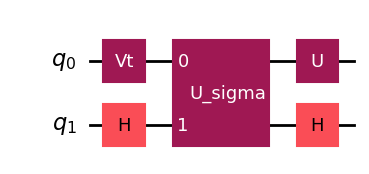

In [100]:
u_sig, v_con_trans, unitary=make_unitary_circuit(non_unitary)
u_sig_circuit = UnitaryGate(u_sig, label='U_sigma')
v_trans_circuit=UnitaryGate(v_con_trans, label='Vt')
unitary_circuit= UnitaryGate(unitary, label='U')
unitary_dilation= QuantumCircuit(2)
unitary_dilation.append(v_trans_circuit,[0])
unitary_dilation.h(1)
unitary_dilation.append(u_sig_circuit, [0, 1])
unitary_dilation.h(1)
unitary_dilation.append(unitary_circuit,[0])
unitary_dilation.draw('mpl')

Optimal Walsh Circuit

In [ ]:
#Defining Matrixes
Pauli_Z=np.array([[1, 0], [0, -1]])
Identity=np.eye(2)

U_diag = np.diag([
    1,
    np.exp(1j * 0.3),     #Good example, because aj1, aj2, aj3, are all non-zero
    np.exp(1j * 0.6),     
    np.exp(1j * 1.2)      
])


In [102]:
def Walsh_Operator(n):
    operators=[]
    for j in range(1, 2**n):
        binary_value=bin(j)[2:].zfill(n)    
        result=None
        for bit in binary_value:
            if bit=='1':
                matrix=Pauli_Z
            else:
                matrix=Identity    
            if result is None:
                result=matrix                         #matrix is identity if bit=0, and pauli_z if bit is 1
            else:
                result=np.kron(result, matrix)
        operators.append(result)
    return operators

In [103]:
#Part of Coefficients Calculator
def fk_vector(matrix):
    diagonal=np.diag(matrix)
    fk=-1j*np.log(diagonal)
    return fk
    

In [104]:
#Test Cell
for i, operators in enumerate(Walsh_Operator(3)):         
    print({i+1}, np.diag(operators))         #Diagonals only

{1} [ 1. -1.  1. -1.  1. -1.  1. -1.]
{2} [ 1.  1. -1. -1.  1.  1. -1. -1.]
{3} [ 1. -1. -1.  1.  1. -1. -1.  1.]
{4} [ 1.  1.  1.  1. -1. -1. -1. -1.]
{5} [ 1. -1.  1. -1. -1.  1. -1.  1.]
{6} [ 1.  1. -1. -1. -1. -1.  1.  1.]
{7} [ 1 -1 -1  1 -1  1  1 -1]


In [105]:
#Part of Coefficients Calculator
def Walsh_matrix(q):
    signs=np.zeros((2**q, 2**q), dtype=int)
    for j in range(2**q):
        j_bin=np.array(list(bin(j)[2:].zfill(q)), dtype=int)
        for k in range(2**q):
            k_bin=np.array(list(bin(k)[2:].zfill(q)), dtype=int)
            bit_product=np.dot(j_bin, k_bin)%2
            signs[j, k]=(-1)**bit_product
    return signs
        
            

In [106]:
def Walsh_coefficients(matrix):
    fk= fk_vector(matrix)
    n=len(fk)
    W=Walsh_matrix(int(np.log2(n)))
    aj=(1/n)* W @ fk
    return aj
    
    

In [107]:
print(np.diag(u_sig))

[1.        +0.j         0.38196601+0.92417637j 1.        +0.j
 0.38196601-0.92417637j]


In [109]:
def gray_code(n):
    return [i ^ (i >> 1) for i in range(2**n)]

In [110]:
gray_code(3)

[0, 1, 3, 2, 6, 7, 5, 4]

In [111]:
def build_walsh_circuit(matrix):
    aj=np.real(Walsh_coefficients(matrix))
    n=int(np.log2(len(aj)))
    qc=QuantumCircuit(n)
  
    
    
    

In [112]:
build_walsh_circuit(u_sig)

In [ ]:
def build_optimal_walsh_circuit(matrix):
    aj = np.real(Walsh_coefficients(matrix))  
    n = int(np.log2(len(aj)))
    gray_seq = gray_code(n)
    qc = QuantumCircuit(n)

    gate_positions = []

    for g in gray_seq:
        if g == 0:
            continue  
        bin_str = format(g, f'0{n}b')
        leftmost_1 = bin_str.find('1')
        qubit = n - 1 - leftmost_1
        gate_positions.append((g, qubit))

    for idx, (g, target) in enumerate(gate_positions):
        angle = -2 * aj[g]
        if abs(angle) < 1e-10:
            continue

        
        if idx == 0:
            qc.append(RZGate(angle), [target])
            continue

        prev_target = gate_positions[idx - 1][1]

       
        if prev_target != target:
            qc.cx(prev_target, target)

        
        qc.append(RZGate(angle), [target])

        xor = g ^ gate_positions[idx - 1][0]
        control_bit = xor.bit_length() - 1
        control = n - 1 - control_bit
        if control != target:
            qc.cx(control, target)

    return qc


In [ ]:
print(Walsh_coefficients(U_diag)) #Corresponding Rz is -2*aj, if aj is 0 the gate is skipped

[ 0.525+6.93889390e-18j -0.225-3.46944695e-17j -0.375+1.38777878e-17j
  0.075+1.38777878e-17j]


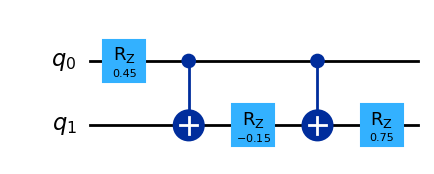

In [114]:
# Example usage
dummy_diag =U_diag


qc =build_optimal_walsh_circuit(dummy_diag)
qc.draw('mpl')